# Integration

In [1]:
import pennylane as qml
from pennylane.optimize import GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

## Simple Integration... Let's start with just 1D integral

### Data Generation

In [2]:
# data = np.load('toy_data_10e4.npz') ## g = y = cos(x1 + 2*x2 + 0.5x3 + alpha0) 3d
data = np.load('cos1d_data_10e4.npz') ## g = y = cos(x1 + alpha0) 1d

In [3]:
Xdata = data['xdata']
print(Xdata)

[[1.70477594 0.        ]
 [3.37372817 0.01002004]
 [0.10208212 0.02004008]
 ...
 [0.1794528  4.97995992]
 [2.07330657 4.98997996]
 [1.39937121 5.        ]]


In [4]:
Ydata = data['ydata']
print(Ydata)

[-0.13357914 -0.97082334  0.99255235 ...  0.43228364  0.71084235
  0.99325801]


### Circuit Model

In [5]:
dev_stochastic = qml.device("lightning.qubit", wires=10)

@qml.qnode(dev_stochastic, diff_method="parameter-shift")
def single_data_point_ansatz(params, phis, x, num_layers):
    num_qubits = math.ceil(len(x) / 2)
    param_index = 0

    for _ in range(num_layers):
        for i in range(len(x)):
        # for i in range(x.shape[-1]):
            qubit = i // 2
            qml.RY(params[param_index], wires=qubit)
            qml.RZ(params[param_index + 1], wires=qubit)
            qml.RZ(x[i], wires=qubit)  # Re-uploading data here
            qml.RZ(params[param_index + 2], wires=qubit)
            qml.RY(params[param_index + 3], wires=qubit)
            qml.RZ(params[param_index + 4], wires=qubit)
            param_index += 5
        
        if num_qubits > 1:
            for q in range(0, num_qubits - 1, 1):
                qml.CZ(wires=[q, q + 1])
            if num_qubits > 2:
                qml.CZ(wires=[num_qubits - 1, 0])
    
    for i in range(num_qubits):
        qml.RY(phis[i], wires=i)

    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)
    
    return qml.expval(obs)

def batch_ansatz(params, phis, xdata, num_layers):
    # Ensure that `params` is a flat list for single_data_point_ansatz
    flat_params = params.flatten()
    
    # Calculate the expectation for each data point and take the mean
    expectations = [single_data_point_ansatz(flat_params, phis, x, num_layers) for x in xdata]
    # return np.mean(expectations)
    return expectations

/home/kban/.local/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


[0.68705152 0.45955556 0.72123594 0.21632995 0.98067372 0.4903365
 0.34235232 0.85522043 0.26480214 0.81999793 0.65684334 0.40929526
 0.72316138 0.09769824 0.34414689 0.62534383 0.68708456 0.52297761
 0.98218463 0.90261664]


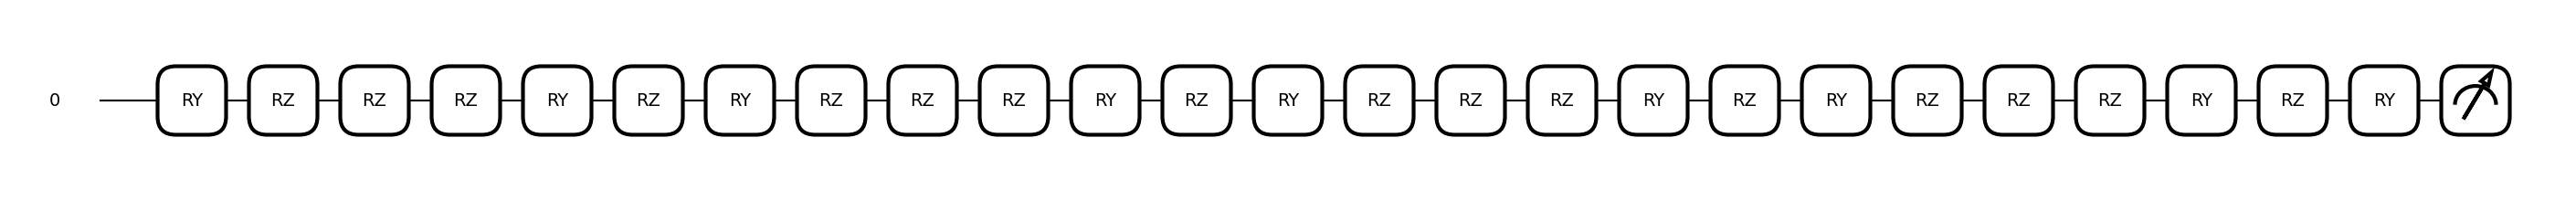

In [8]:
xdim = 2
num_qubits = math.ceil(xdim / 2)
num_layers = 2

N = 300
xdata = Xdata[:N] #np.random.uniform(size = [100,xdim], requires_grad=False)
target = Ydata[:N]

xdata_val = Xdata[N:N+50]
target_val = Ydata[N:N+50]

thetas = np.random.uniform(size = xdim*num_layers*5,requires_grad = True)
phis = np.random.uniform(size=(num_qubits,), requires_grad =True)

print(thetas)

params = 0
params += thetas
param_index = 1
for _ in range(num_layers):
    for j in range(xdim):
        params[param_index] = thetas[param_index] * xdata[0][j]
        param_index += 5

fig, ax = qml.draw_mpl(single_data_point_ansatz)(params, phis, xdata[0], num_layers)
plt.show()

### Loss function

In [9]:
from scipy.optimize import minimize
from copy import deepcopy

In [10]:
def cost_function(params, phis, xdata, target, num_layers, normalize=True):
    # Generate predictions using the provided ansatz
    predictions = batch_ansatz(params, phis, xdata, num_layers)
    
    # Normalize target values if requested
    if normalize:
        norm = np.abs(target) + 1e-7  # Adding a small value to avoid division by zero
    else:
        norm = 1.0
    
    # Calculate normalized MSE loss
    loss = np.mean(((predictions - target) ** 2) / norm)
    return loss


# 수동 그라디언트 계산 함수
def parameter_shift_term(qnode, params, i, phis, xdata, num_layers):
    GEN_EIGENVAL = 0.5  
    shift = np.pi / (4 * GEN_EIGENVAL) 
    
    # 각 파라미터에 대한 기울기를 계산합니다.
    shifted_params = deepcopy(params)  # 원본 파라미터의 깊은 복사본을 생성합니다.
    shifted_params[i] += shift
    forward = np.mean([qnode(shifted_params, phis, x, num_layers) for x in xdata])  # Forward evaluation

    shifted_params[i] = params[i] - shift
    backward = np.mean([qnode(shifted_params, phis, x, num_layers) for x in xdata])  # Backward evaluation

    # 그라디언트 계산
    gradient = (forward - backward) / 2
    return gradient


def parameter_shift_grad(qnode, params, phis, xdata, num_layers):
    gradients = np.zeros_like(params)
    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i, phis, xdata, num_layers)
    return gradients

In [11]:
# 각 epoch마다 실행할 최적화 함수
def optimize_epoch(params, phis, xdata, target, num_layers, maxiter=100):
    # 최적화할 목적 함수
    def objective(params):
        # 파라미터를 적절한 형태로 재구성
        reshaped_params = params.reshape((num_layers, -1))
        # 손실 계산
        loss = cost_function(reshaped_params, phis, xdata, target, num_layers)
        return loss

    # 최적화 실행
    result = minimize(objective, params.flatten(), method='L-BFGS-B',
                      options={'maxiter': maxiter,
                                'gtol': 1e-12,  # 그래디언트의 norm이 이 값 이하로 떨어지면 최적화를 중단
                                'ftol': 1e-18   # 상대적인 함수의 감소량이 이 값 이하로 떨어지면 최적화를 중단
    })
    
    # 최적화된 파라미터
    optimized_params = result.x.reshape(params.shape)
    return optimized_params, result.fun

# 검증 손실을 계산하기 위한 함수
def validate(params, phis, xdata_val, target_val, num_layers):
    loss = cost_function(params, phis, xdata_val, target_val, num_layers)
    return loss

In [12]:
# 전체 최적화 과정을 여러 epoch에 걸쳐 실행
epochs = 50
for epoch in range(epochs):
    # 여기서 maxiter=1로 설정하여 각 epoch마다 최적화를 1회 반복
    params, loss = optimize_epoch(params, phis, xdata, target, num_layers, maxiter=1) 
    
    val_loss = validate(params, phis, xdata_val, target_val, num_layers)
    
    print(f"Epoch {epoch+1}: Training Loss = {loss}, Validation Loss = {val_loss}")


# 최종 최적화된 파라미터와 손실 출력
print(f"Final Loss: {loss}")
print(f"Optimized Parameters: {params}")

Epoch 1: Training Loss = 0.5193423800448062, Validation Loss = 0.44094152434619716
Epoch 2: Training Loss = 0.12038267260322677, Validation Loss = 0.11448639138545139
Epoch 3: Training Loss = 0.09815452484704823, Validation Loss = 0.05755527641152085
Epoch 4: Training Loss = 0.0861683267713715, Validation Loss = 0.070860276364721
Epoch 5: Training Loss = 0.076853581900851, Validation Loss = 0.04590538000024719
Epoch 6: Training Loss = 0.0675990112136236, Validation Loss = 0.05704987482677124
Epoch 7: Training Loss = 0.05448620454804144, Validation Loss = 0.03143910581131065
Epoch 8: Training Loss = 0.049587059222901596, Validation Loss = 0.039235600330602166
Epoch 9: Training Loss = 0.0428961933973042, Validation Loss = 0.024736636445389492
Epoch 10: Training Loss = 0.03939674389486391, Validation Loss = 0.029803768640774716
Epoch 11: Training Loss = 0.035278799580426755, Validation Loss = 0.02053034074255118
Epoch 12: Training Loss = 0.03256154544240194, Validation Loss = 0.0241940782

### Check the results

In [13]:
predictions = batch_ansatz(params, phis, Xdata[400:420], num_layers)

In [14]:
Ydata[400:420], np.array(predictions)

(array([ 0.68859976,  0.97227901,  0.63050092,  0.78966693,  0.51416276,
         0.95545231,  0.9470455 ,  0.72431934,  0.96773803, -0.55161517,
         0.20404097,  0.95696629,  0.97480826,  0.72071072,  0.39053937,
        -0.41654036,  0.99991996,  0.54218907,  0.8926306 ,  0.87943899]),
 tensor([ 0.77186155,  0.94500824,  0.7186661 ,  0.85842838,  0.50299691,
          0.9821923 ,  0.97706536,  0.69612371,  0.98903634, -0.48702858,
          0.2282714 ,  0.92926405,  0.9926374 ,  0.79663213,  0.3977278 ,
         -0.34861439,  0.99536033,  0.53507879,  0.93815744,  0.92798153], requires_grad=True))

In [15]:
predictions = batch_ansatz(params, phis, Xdata[0:20], num_layers)

In [16]:
Ydata[0:20], np.array(predictions)

(array([-0.13357914, -0.97082334,  0.99255235, -0.98046538, -0.96324292,
        -0.817155  ,  0.45767458,  0.95902655,  0.99646787,  0.36033158,
         0.4533931 ,  0.6208793 , -0.95646062,  0.61212022, -0.13304606,
         0.83947275, -0.61675439, -0.99953003, -0.0376312 , -0.96854291]),
 tensor([-0.13118386, -0.88986157,  0.89012809, -0.90475463, -0.87906792,
         -0.81813041,  0.44852073,  0.86964643,  0.88794617,  0.35548233,
          0.44305724,  0.5956196 , -0.93697101,  0.58713172, -0.13472377,
          0.77903127, -0.62636839, -0.94545065, -0.03909277, -0.88851581], requires_grad=True))

### Plot $g(x)$

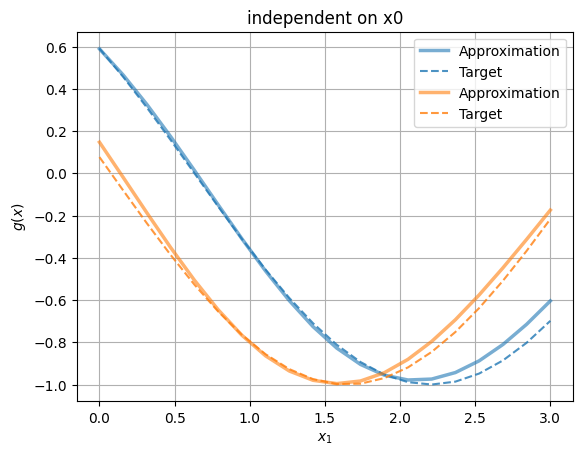

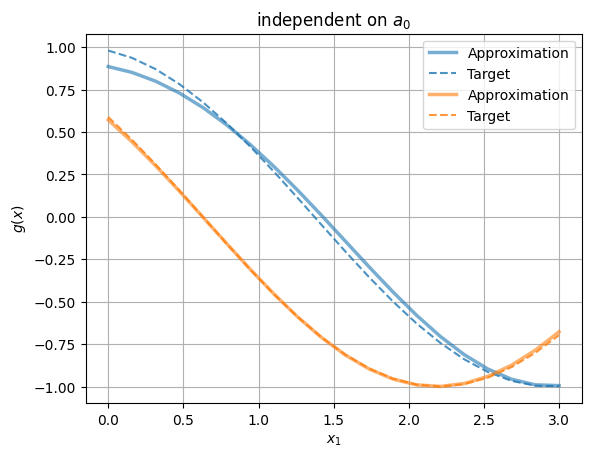

In [49]:
import copy

xmin = [0.0]
xmax = [3.0]
npoints = 20

xmin = np.array(xmin*xdim)
xmax = np.array(xmax*xdim)

def target(x):
    return np.cos(x[0]+x[1])

for d in range(xdim):
    # Create a linear space in the dimension we are plotting
    xlin = np.linspace(xmin[d], xmax[d], npoints)

    for i in range(xdim):
        # For every extra dimension do an extra plot so that we have more random points
        # in the other dimensions

        # Select a random point in the other dimensions
        xran_origin = np.random.rand(xdim) * (xmax - xmin) + xmin

        ytrue = []
        all_xs = []

        for xx in xlin:
            xran = copy.deepcopy(xran_origin)
            xran[d] = xx
            ytrue.append(target(xran))
            all_xs.append(xran)

        ypred = batch_ansatz(params, phis, all_xs, num_layers)

        if xdim == 2:
            # when there is only 2 dimensions only one variable is fixed
            # and so we can actually write the numerical value
            other_d = (d + 1) % 2
        else:
            tag = f"n={i}"

        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

        plt.plot(
            xlin,
            ypred,
            label=f"Approximation",
            linewidth=2.5,
            alpha=0.6,
            ls="-",
            color=color,
        )
        plt.plot(
            xlin,
            np.stack(ytrue),
            label=f"Target",
            linewidth=1.5,
            alpha=0.8,
            ls="--",
            color=color,
        )

    plt.grid(True)
    if d == xdim-1:
        plt.title(f"independent on $a_0$")
    else:
        plt.title(f"independent on x"+str(d))

    plt.xlabel(r"$x_1$")

    plt.ylabel(r"$g(x)$")
    plt.legend()
    plt.show()


### How to get the integration values?